# In-Depth Climate Analysis of Houston (2000 - 2025)
In the previous course of this specialization, *Global Climate Change Policies and Analysis*, I completed a brief analysis of the temperature and precipitation of Houston, Texas in my final project. This project differs from that one in that it is narrowed to June 2000 - May 2025 (rather than 1931-2024), looks at a broader range of weather data, and provides more insight into the changes of Houston's climate over the last 25 years. For this class, *Modeling Climate Anomalies with Statistical Analysis*, the data wrangling will focus more on identifying outliers rather than analyzing long-term patterns.
## Preprocessing
The data for this project was pulled from the NOAA website and represents daily measurements from William Hobby Airport, just east of downtown Houston. This is the same station used for the previous project and has a full record of the data needed from June 2000 to May 2025.

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [155]:
data = pd.read_csv('HOU-Airport_InDepth-Daily-Weather-Reports_2000-2025.csv')
df = pd.DataFrame(data)
df.head()

,STATION,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT02,WT03,WT04,...,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21
0,USW00012918,6/1/2000,5.59,0.00,91.0,74.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00012918,6/2/2000,6.04,0.00,92.0,72.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,USW00012918,6/3/2000,5.37,0.00,90.0,74.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00012918,6/4/2000,8.72,0.06,91.0,75.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,USW00012918,6/5/2000,7.16,0.78,81.0,71.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN


In [156]:
# Rename columns and remove station column
df.rename(columns= {'DATE': 'date',
                    'AWND': 'avg_wind',
                    'PRCP': 'precipitation',
                    'TMAX': 'max_temp',
                    'TMIN': 'min_temp',
                    'WT01': 'fog_', # may include heavy fog
                    'WT02': 'heavy_fog',
                    'WT03': 'thunder',
                    'WT04': 'ice_pellets',
                    'WT05': 'hail_', # may include ice pellets (small hail)
                    'WT06': 'ground_ice',
                    'WT07': 'dust',
                    'WT08': 'haze',
                    'WT09': 'drifting_snow',
                    'WT10': 'tornado',
                    'WT11': 'high_winds',
                    'WT13': 'mist',
                    'WT14': 'drizzle',
                    'WT15': 'freezing_drizzle',
                    'WT16': 'rain_', # may include drizzle, freezing drizzle, and freezing rain
                    'WT17': 'freezing_rain',
                    'WT18': 'snow_',
                    'WT21': 'ground_fog'},
                    inplace=True)
df.drop('STATION', axis=1, inplace=True)
df.columns

Index(['date', 'avg_wind', 'precipitation', 'max_temp', 'min_temp', 'fog_',
       'heavy_fog', 'thunder', 'ice_pellets', 'hail_', 'ground_ice', 'dust',
       'haze', 'drifting_snow', 'tornado', 'high_winds', 'mist', 'drizzle',
       'freezing_drizzle', 'rain_', 'freezing_rain', 'snow_', 'ground_fog'],
      dtype='object')

In [157]:
# Combine weather type columns of similar weather
# identify columns to aggregate into new columns
new_cols = {'fog': ['fog_', 'heavy_fog', 'ground_fog'],
            'hail': ['ice_pellets', 'hail_'],
            'poor_air_quality': ['dust', 'haze'],
            'snow': ['drifting_snow', 'snow_'],
            'rain': ['mist', 'drizzle', 'freezing_drizzle', 'rain_', 'freezing_rain']}
# aggregate columns in list into column with name of key, then drop the columns in the list
for col_name, old_cols in new_cols.items():
    df[col_name] = df[old_cols].min(axis=1)
    df.drop(old_cols, axis = 1, inplace=True)
df.head()

,date,avg_wind,precipitation,max_temp,min_temp,thunder,ground_ice,tornado,high_winds,fog,hail,poor_air_quality,snow,rain
0,6/1/2000,5.59,0.00,91.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6/2/2000,6.04,0.00,92.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,6/3/2000,5.37,0.00,90.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6/4/2000,8.72,0.06,91.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,6/5/2000,7.16,0.78,81.0,71.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [158]:
# Check for nulls.
df.isnull().sum()

date                   0
avg_wind               7
precipitation          2
max_temp               3
min_temp               2
thunder             7522
ground_ice          9125
tornado             9130
high_winds          9103
fog                 5663
hail                8840
poor_air_quality    8097
snow                9094
rain                6757
dtype: int64

In [159]:
# for first five columns, if null drop row
df.dropna(inplace=True, subset=['date', 'avg_wind', 'precipitation', 'max_temp', 'min_temp'])
# for weather type columns, if null replace with 0
df.fillna(0, inplace=True)

df.head()    

,date,avg_wind,precipitation,max_temp,min_temp,thunder,ground_ice,tornado,high_winds,fog,hail,poor_air_quality,snow,rain
0,6/1/2000,5.59,0.00,91.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6/2/2000,6.04,0.00,92.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6/3/2000,5.37,0.00,90.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6/4/2000,8.72,0.06,91.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6/5/2000,7.16,0.78,81.0,71.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [160]:

df.dtypes

date                 object
avg_wind            float64
precipitation       float64
max_temp            float64
min_temp            float64
thunder             float64
ground_ice          float64
tornado             float64
high_winds          float64
fog                 float64
hail                float64
poor_air_quality    float64
snow                float64
rain                float64
dtype: object

In [161]:
# make date column in date format
df['date'] = pd.to_datetime(df['date'])

# make weather type columns as bool
weather_columns = [*new_cols.keys()] + ['thunder', 'ground_ice', 'tornado', 'high_winds']
for weather_type in weather_columns:
    df[weather_type] = df[weather_type].astype(bool)

df.dtypes

date                datetime64[ns]
avg_wind                   float64
precipitation              float64
max_temp                   float64
min_temp                   float64
thunder                       bool
ground_ice                    bool
tornado                       bool
high_winds                    bool
fog                           bool
hail                          bool
poor_air_quality              bool
snow                          bool
rain                          bool
dtype: object

In [162]:
# create a column that represents just the year so we can work by year for our plots without aggregating the data
df['year'] = df['date'].dt.year
df.head()

,date,avg_wind,precipitation,max_temp,min_temp,thunder,ground_ice,tornado,high_winds,fog,hail,poor_air_quality,snow,rain,year
0,2000-06-01,5.59,0.00,91.0,74.0,False,False,False,False,False,False,False,False,False,2000
1,2000-06-02,6.04,0.00,92.0,72.0,False,False,False,False,False,False,False,False,True,2000
2,2000-06-03,5.37,0.00,90.0,74.0,False,False,False,False,False,False,False,False,False,2000
3,2000-06-04,8.72,0.06,91.0,75.0,False,False,False,False,False,False,False,False,True,2000
4,2000-06-05,7.16,0.78,81.0,71.0,False,False,False,False,True,False,False,False,True,2000


In [163]:
# I realized that my data will be off if I continue with the data for 2000 and 2025 in since they are partials, so I am removing that here.
df = df[(df['year'] != 2000) & (df['year'] != 2025)]
print(df['date'].head())
print(df['date'].tail())

214   2001-01-01
215   2001-01-02
216   2001-01-03
217   2001-01-04
218   2001-01-05
Name: date, dtype: datetime64[ns]
8975   2024-12-27
8976   2024-12-28
8977   2024-12-29
8978   2024-12-30
8979   2024-12-31
Name: date, dtype: datetime64[ns]


The data now is free of nulls, in the correct formats, and is more useful for our purposes.
## Analysis
I realized at this point that the assignment asked for analysis of ground water. However, this was not available to a full extent, so if you would allow me to analyze the weather types instead, I would be grateful.
I will be looking at outliers for maximum and minimum temperatures, precipitation, average wind speeds, and instances of each weather type. This will be represented as boxplots for each year.

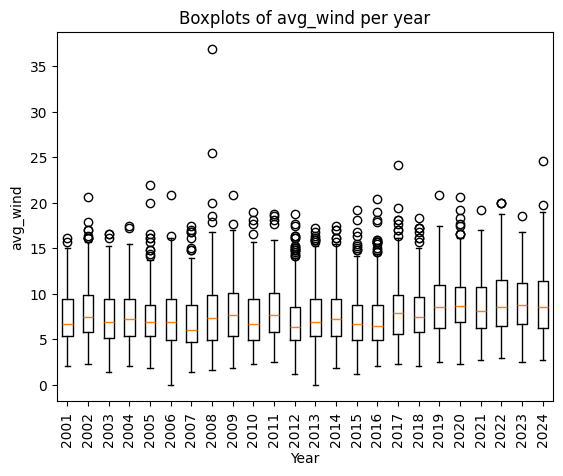

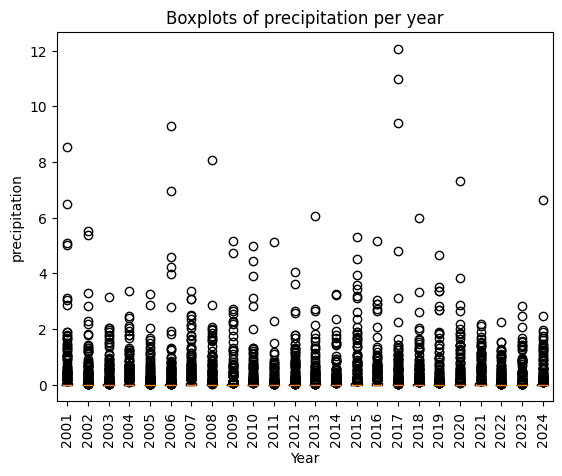

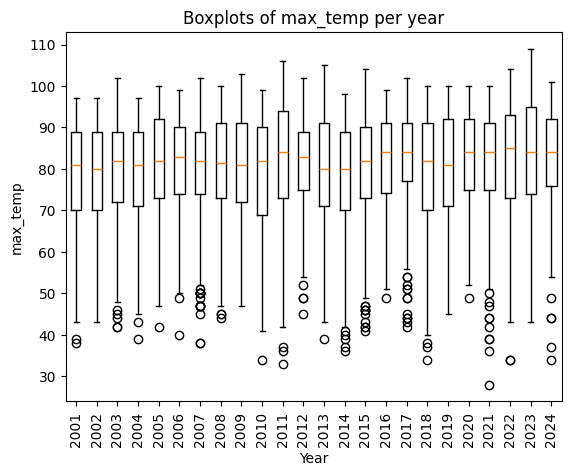

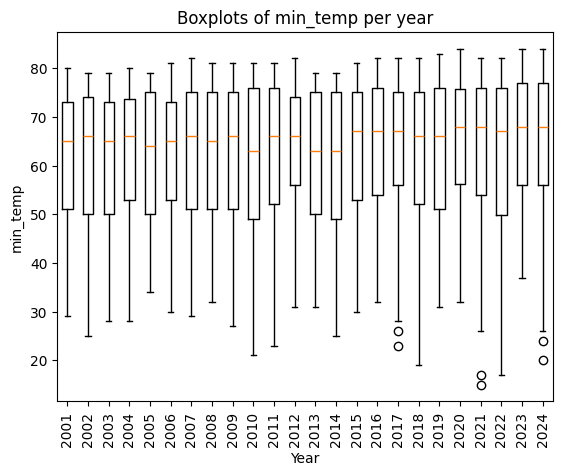

In [164]:
# write function to create list of arrays for each year for the indicated column of data
# this will make graphing items easier
data_columns = ['avg_wind', 'precipitation', 'max_temp', 'min_temp']
years = sorted(set(df['year']))
for data_column in data_columns:
    plt.figure()
    year_data = []
    for year in years:
        array = df.loc[df['year'] == year, data_column].values
        year_data.append(array)
    plt.boxplot(year_data)
    plt.title(f'Boxplots of {data_column} per year')
    plt.ylabel(f'{data_column}')
    plt.xlabel('Year')
    plt.xticks(range(1, len(years)+1), years, rotation=90)
    plt.show()

### Average Wind
- The average wind speeds for 2001-2024 have increased slightly, especially since 2019. The cause for this is not immediately clear. However, it may be assumed that this has gradually changed Houston's climate.
- There are four outliers in the average wind data that stand out: two in 2008, one in 2017, and one in 2024. Finding the max for each of these years may clarify the causal event. (I know of these because I experience all but Ike, though Ike is infamous in the city.)
    - September 2008: Hurricane Ike
    - August 2017: Hurricane Harvey
    - July 2024: Hurricane Beryl

In [165]:
avg_wind_outlier_years = [2008, 2017, 2024]
max_avg_wind_dates = []
for wind_outlier_yr in avg_wind_outlier_years:
    yr = df.loc[df['year'] == wind_outlier_yr, ['avg_wind', 'date']]
    max_avg_wind_date = yr.loc[yr['avg_wind'] == max(yr['avg_wind']), 'date']
    max_avg_wind_dates.append(max_avg_wind_date)
print(max_avg_wind_dates)

[3026   2008-09-13
Name: date, dtype: datetime64[ns], 6298   2017-08-29
Name: date, dtype: datetime64[ns], 8803   2024-07-08
Name: date, dtype: datetime64[ns]]


### Precipitation
The average precipitation is at about 0 for each year, indicating that most days go without rain. However, we can identify anomaly events by looking at the instances over 6 inches. These include:
- June 2001: Tropical Storm Allison
- June 2006: Flood (To see a full list of flood events, click __[here](https://www.hcfcd.org/portals/62/about/flooding-history/historytimeline-24x36-1.pdf)__.)
- September 2008: Hurricane Ike
- August 2017: Hurricane Harvey
- September 2020: Tropical Storm Beta
- July 2024: Hurricane Beryl

In [168]:
prcp_outlier_years = [2001, 2006, 2008, 2017, 2020, 2024]
max_prcp_dates = []
for prcp_outlier_yr in prcp_outlier_years:
    yr = df.loc[df['year'] == prcp_outlier_yr, ['precipitation', 'date']]
    max_prcp_date = yr.loc[yr['precipitation'] == max(yr['precipitation']), 'date']
    max_prcp_dates.append(max_prcp_date)
print(max_prcp_dates)

[369   2001-06-05
Name: date, dtype: datetime64[ns], 2209   2006-06-19
Name: date, dtype: datetime64[ns], 3026   2008-09-13
Name: date, dtype: datetime64[ns], 6295   2017-08-26
Name: date, dtype: datetime64[ns], 7418   2020-09-22
Name: date, dtype: datetime64[ns], 8803   2024-07-08
Name: date, dtype: datetime64[ns]]


### Maximum Temperature
The average of maximum temperatures has increased over the years. Interestingly, the outliers are all on the bottom side of the boxplots. Only one stands out as particularly abnormal. This event in 2021 must have been the "SNOVID" event that shut down the entire state of Texas in February of that year due to a complete failure of the power grid after days below freezing temperatures.

In [169]:
yr = df.loc[df['year'] == 2021, ['max_temp', 'date']]
outlier_max_temp_date = yr.loc[yr['max_temp'] == min(yr['max_temp']), 'date']
print(outlier_max_temp_date)

7564   2021-02-15
Name: date, dtype: datetime64[ns]


### Minimum Temperature
The average of minimum temperatures has also increased over the past quarter century. However, this plot has far fewer outliers. Surprisingly, these outliers are also on the bottom side of the graph for the years 2017, 2021, and 2024. Again, the 2021 lows can be explained by SNOVID. However, the other two dates do not stand out in the collective memory of Houstonians (in-person or digitally).


In [171]:
min_temp_outlier_years = [2017, 2021, 2024]
min_temp_dates = []
for mintemp_outlier_yr in min_temp_outlier_years:
    yr = df.loc[df['year'] == mintemp_outlier_yr, ['min_temp', 'date']]
    mintemp_date = yr.loc[yr['min_temp'] == min(yr['min_temp']), 'date']
    min_temp_dates.append(mintemp_date)
print(min_temp_dates)

[6064   2017-01-07
Name: date, dtype: datetime64[ns], 7565   2021-02-16
Name: date, dtype: datetime64[ns], 8629   2024-01-16
Name: date, dtype: datetime64[ns]]


### Extreme Weather Events
Finally, I'd like to analyze the frequency of extreme weather events in Houston. Some of these events were mentioned in earlier analysis, but now we will shift focus to those specifically indicated in the weather type columns. The most uncommon events in Houston include ground ice (or glaze), tornados, hail, and poor air quality (due to dust, smoke, and haze from pollution).

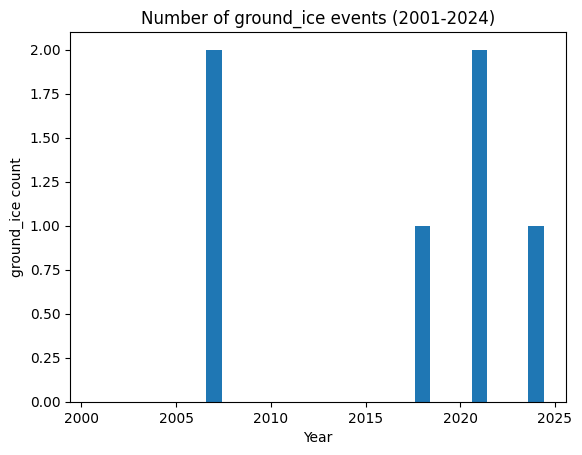

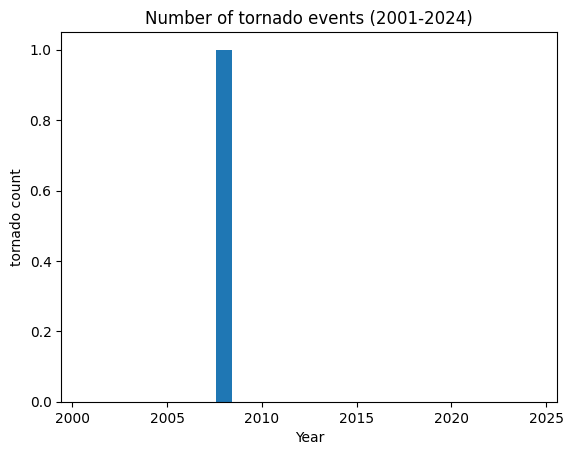

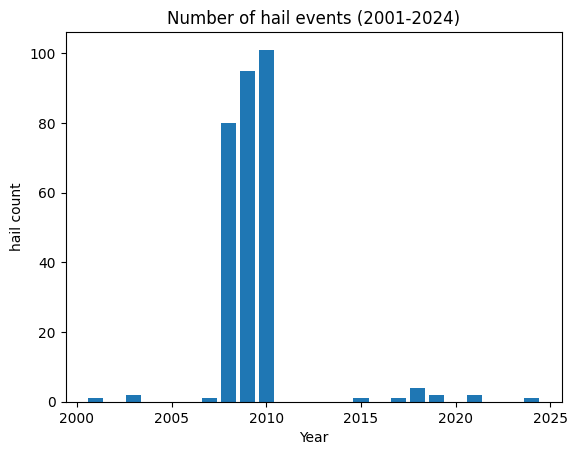

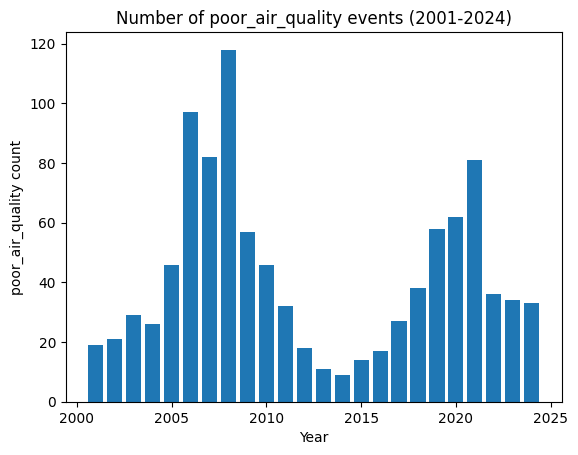

In [181]:
# get counts of True for each year then plot on histogram for each event type
extreme_events = ['ground_ice', 'tornado', 'hail', 'poor_air_quality']
for event in extreme_events:
    plt.figure()
    year_data = []
    for year in years:
        num_events = df.loc[df['year'] == year, event].sum()
        year_data.append(num_events)
    #frequencies = year_data / sum(year_data)
    plt.bar(years, year_data)
    plt.title(f'Number of {event} events (2001-2024)')
    plt.ylabel(f'{event} count')
    plt.xlabel('Year')
    plt.show()

The number of ground ice events is fairly correlated with the minimum temperature outliers. It is possible we are seeing an increase in these cold weather events, but more data would need to be collected before this pattern could be determined with any level of surity.

There is a single tornado event in almost 25 years. This is an extremely rare occurence, as supported by the data. No conclusions can be made from this.

There were a huge number of hail events in the late 2000s. This may indicate a change in reporting during these years as no known weather patterns immediately explain the drastic shift. Further investigation is needed here.

Finally, poor air quality was on the rise until around 2008, decreased until 2014, then increased until 2021. In the last three years, the number of days with poor air quality has leveled out to around 30. These ups and downs roughly follow the price of oil in the United States. Because Houston is home to many refineries and manufacturing plants, I hypothesize that the volume of production at these industrial facilities directly correlates to the number of days with poor air quality. In short, when the economy is good, the air quality is poorer, and vice versa.

![Oil Prices](crude-oil-price-history-chart-2025-06-03-macrotrends.png)